In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.math import argmax
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import os
from gym import spaces

C:\ProgramData\Miniconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWar

In [2]:
rng = np.random.default_rng(358)

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
disc_actions_num = 4

In [4]:
# https://www.gymlibrary.ml/environments/box2d/lunar_lander/

In [5]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()
    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x
    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

def get_actor(num_states, num_actions=1, upper_bound=1, continuous=True, layer1=400, layer2=300, 
              init_weights_min=-0.003, init_weights_max=0.003):
    last_init = tf.random_uniform_initializer(minval=init_weights_min, maxval=init_weights_max)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    
    # Different output activation based on discrete or continous version
    if continuous:
        outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    else:
        outputs = layers.Dense(disc_actions_num, activation="softmax", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    return tf.keras.Model(inputs, outputs)

def get_critic(num_states, num_actions=1, continuous=True, layer1=400, layer2=300):
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(32, activation="relu")(state_input)
    #state_out = layers.Dense(32, activation="relu")(state_out)

    if continuous:
        action_input = layers.Input(shape=(num_actions,))
    else:
        action_input = layers.Input(shape=(disc_actions_num,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)
    outputs = layers.Dense(num_actions)(out)
#     if continuous:
#         outputs = layers.Dense(num_actions)(out)
#     else:
#         outputs = layers.Dense(disc_actions_num)(out)

    return tf.keras.Model([state_input, action_input], outputs)

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [22]:
class Agent:
    def __init__(self, num_states, num_actions=1, lower_bound=-1, upper_bound=1, continuous=True,
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005, epsilon=0.2, adam_critic_eps=1e-07,
            adam_actor_eps=1e-07, actor_amsgrad=False, critic_amsgrad=False, actor_layer_1=256, 
            actor_layer_2=256, critic_layer_1=256, critic_layer_2=256):
        
        self.continuous = continuous
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        
        # For methods
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        if self.continuous:
            self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        else:
            self.action_buffer = np.zeros((self.buffer_capacity, disc_actions_num))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        # Also keep track if it is in terminal state (legs on ground)
        self.done_buffer = np.zeros((self.buffer_capacity, 1)).astype(np.float32)
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        # Epsilon in epsilon-greedy
        self.epsilon = epsilon
        
        self.actor_model = get_actor(
            num_states, num_actions, upper_bound, continuous=continuous, layer1=actor_layer_1, layer2=actor_layer_2
        )
        self.critic_model = get_critic(
            num_states, num_actions, continuous=continuous, layer1=critic_layer_1, layer2=critic_layer_2
        )
        
        self.target_actor = get_actor(
            num_states, num_actions, upper_bound, continuous=continuous, layer1=actor_layer_1, layer2=actor_layer_2
        )
        self.target_critic = get_critic(
            num_states, num_actions, continuous=continuous, layer1=critic_layer_1, layer2=critic_layer_2
        )
        
        self.actor_optimizer = tf.keras.optimizers.Adam(
            learning_rate=actor_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_actor_eps, amsgrad=actor_amsgrad,
        )
        self.critic_optimizer = tf.keras.optimizers.Adam(
            learning_rate=critic_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_critic_eps, amsgrad=critic_amsgrad,
        )
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple + terminal state
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1
    
    # Calculation of loss and gradients
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            # Add done_batch to y function for terminal state
            y = reward_batch + done_batch * self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            l = losses.MeanSquaredError()
            critic_loss = l(y, critic_value)

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        
        # Gradient clipping to avoid exploding and vanishing gradients
        critic_gvd = zip(critic_grad, self.critic_model.trainable_variables)
        critic_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in critic_gvd]
        
        self.critic_optimizer.apply_gradients(critic_capped_grad)

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        # clip actor too
        actor_gvd = zip(actor_grad, self.actor_model.trainable_variables)
        actor_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in actor_gvd]
        
        self.actor_optimizer.apply_gradients(actor_capped_grad)

    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
    def policy(self, state, noise_object=0, use_noise=True, noise_mult=1):
        # Default noise_object to 0 for when it is not needed
        # For doing actions without added noise
        if not use_noise:    
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return [np.squeeze(legal_action)][0]
            else:
                return self.actor_model(state)
        else:
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state))
                
                noise = noise_object()
                # Adding noise to action
                sampled_actions = sampled_actions.numpy() + noise * noise_mult

                # We make sure action is within bounds
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return [np.squeeze(legal_action)][0]
            else:
                if (rng.random() < self.epsilon):
                    #random move
                    action = np.zeros(disc_actions_num)
                    action[np.random.randint(0, disc_actions_num, 1)[0]] = 1
                    return action
                else:
                    return self.actor_model(state)

In [23]:
rng.random()

0.5441492862750589

In [24]:
def fixed(x, episode):
    return x

In [25]:
def run(total_trials=1, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.3, critic_lr=0.003, render=False,
            actor_lr=0.002, gamma=0.99, tau=0.005, noise_mult=1, save_weights=True, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=20, output=True,
            return_rewards=False, total_time=True, use_guide=False, solved=200,
            continuous=True, environment='LunarLander-v2', seed=1453, start_steps=0,
            gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5,
            epsilon=0.2, epsilon_func=fixed, adam_critic_eps=1e-07, adam_actor_eps=1e-07,
            actor_amsgrad=False, critic_amsgrad=False, actor_layer_1=256, actor_layer_2=256,
            critic_layer_1=256, critic_layer_2=256):
    tot_time = time.time()
    
    if environment == 'LunarLander-v2':
        env = gym.make(
            "LunarLander-v2",
            continuous=continuous,
            gravity=gravity,
            enable_wind=enable_wind,
            wind_power=wind_power,
            turbulence_power=turbulence_power
        )
    else:
        env = gym.make(environment)
        
    # Apply the seed
    _ = env.reset(seed=seed)
        
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):
        # Stepcount used for random start
        step = 0

        # Add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=buffer_capacity, 
                batch_size=batch_size, std_dev=std_dev, critic_lr=critic_lr, actor_lr=actor_lr, 
                gamma=gamma, tau=tau, epsilon=epsilon, adam_critic_eps=adam_critic_eps, adam_actor_eps=adam_actor_eps,
                actor_amsgrad=actor_amsgrad, critic_amsgrad=critic_amsgrad, actor_layer_1=actor_layer_1, 
                actor_layer_2=actor_layer_2, critic_layer_1=critic_layer_1, critic_layer_2=critic_layer_2)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            agent.epsilon = epsilon_func(epsilon, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, noise_object=agent.ou_noise, noise_mult=noise_mult)
                else:
                    action = env.action_space.sample()
                
                step += 1
                
                # Recieve state and reward from environment.
                if continuous:
                    state, reward, done, info = env.step(action)
                else:
                    state, reward, done, info = env.step(np.argmax(action))
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Reward modification
                if use_guide:
                    # giving penalty for straying far from flags and having high speed
                    # x max
#                     reward -= int(abs(state[0]) > 0.15) * 2 * abs(state[0])
#                     # y top
#                     reward -= int(state[1] > 1) * state[1] / 2
#                     # horizontal speed
#                     reward -= int(abs(state[2]) > 1) * abs(state[2])
#                     # down speed
#                     reward -= int(state[3] <  -1) * abs(state[3])
#                     # up speed
#                     reward -= int(state[3] > 0.1) * 3 * state[3]
                    reward -= abs(state[2]/2) + abs(state[3]) + (abs(state[0])) + (abs(state[1])/2)

                # Add terminal state for when it has landed. Just look at legs on the ground.
                terminal_state = int(not done)#int(not (state[6] and state[7]))
                agent.record((prev_state, action, reward, state, terminal_state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            true_reward_list[trial].append(true_reward)
            
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            avg_reward_list[trial].append(avg_reward)
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)
            
            if output:
                print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, 
                          true_reward, (time.time() - before), step))
            
            # Stop if avg is above 'solved'
            if true_avg_reward >= solved:
                break

        # Save weights
        now = datetime.datetime.now()
        timestamp = "{}.{}.{}.{}.{}.{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
        save_name = "{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
            environment, total_episodes, 
            buffer_capacity, batch_size, 
            std_dev, critic_lr, actor_lr, 
            gamma, tau, noise_mult, 
            gamma_func.__name__, tau_func.__name__, 
            critic_lr_func.__name__, actor_lr_func.__name__, 
            noise_mult_func.__name__, std_dev_func.__name__, 
            mean_number, use_guide, 
            solved, continuous, 
            start_steps, gravity, 
            enable_wind, wind_power,
            turbulence_power, 
            epsilon, epsilon_func.__name__,
            adam_critic_eps, adam_actor_eps,
            actor_amsgrad, critic_amsgrad,
            actor_layer_1, actor_layer_2,
            critic_layer_1, critic_layer_2,
            timestamp,
        )
        if save_weights:
            try:
                agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('actor save fail')
            try:
                agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('critic save fail')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    try:
        plt.savefig('Graphs/' + save_name + '.png')
    except:
        print('save fig fail')
    plt.show()
    
    print('total time:', time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [26]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False,
        environment="LunarLander-v2", continuous=True, gravity=-10.0, enable_wind=False,
        wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power
    )
    
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=0, batch_size=0, 
                std_dev=0, critic_lr=0, actor_lr=0, gamma=0, tau=0, epsilon=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(state=tf_prev_state, use_noise=False)

            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [27]:
def random(total_episodes=10, render=False, environment="LunarLander-v2", continuous=True,
        gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, seed=1453):
    
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power,
    )
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [28]:
xax = [x for x in range(-600,250)]

In [29]:
def decreasing_std(x, episode):
    return max(0, min(0.2, 0.2 - (x+500)*(0.2/700)))

In [30]:
def decreasing_alr(x, episode):
    return max(0, min(0.0002, 0.0002 - (x+500)*(0.0002/700)))

In [31]:
def decreasing_clr(x, episode):
    return max(0, min(0.0004, 0.0004 - (x+500)*(0.0004/700)))

In [32]:
def decreasing_tau(x, episode):
    return max(0, min(0.002, 0.002 - (x+500)*(0.002/700)))

In [33]:
def decreasing_eps(x, episode):
    return max(0, min(0.3, 0.3 - (x+500)*(0.3/700)))

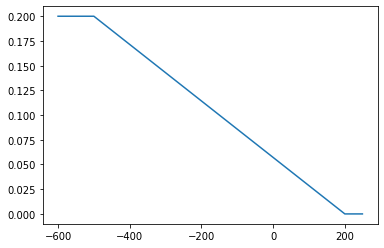

In [34]:
plt.plot(xax,[decreasing_std(x,1) for x in range(-600,250)])

In [35]:
#test(render=True, continuous=False, actor_weights='Weights/actor-trial0_LunarLander-v2_500_20000_64_0.3_0.0002_0.0001_0.99_0.001_1_fixed_fixed_fixed_fixed_fixed_fixed_20_False_200_False_5000_-10.0_False_15.0_1.5_0.2.h5')

In [ ]:
run(total_trials=1, total_episodes=600, gamma=0.999, buffer_capacity=200000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=1000, continuous=False, epsilon_func=decreasing_eps)

Ep 0 * AvgReward -136.86 * true AvgReward -136.86 * Reward -136.86 * True Reward -136.86 * time 1.25 * step 81
Ep 1 * AvgReward -144.18 * true AvgReward -144.18 * Reward -151.49 * True Reward -151.49 * time 0.37 * step 157
Ep 2 * AvgReward -144.49 * true AvgReward -144.49 * Reward -145.11 * True Reward -145.11 * time 0.34 * step 229
Ep 3 * AvgReward -119.67 * true AvgReward -119.67 * Reward -45.21 * True Reward -45.21 * time 0.33 * step 299
Ep 4 * AvgReward -92.41 * true AvgReward -92.41 * Reward 16.64 * True Reward 16.64 * time 0.39 * step 377
Ep 5 * AvgReward -92.87 * true AvgReward -92.87 * Reward -95.20 * True Reward -95.20 * time 0.26 * step 433
Ep 6 * AvgReward -100.00 * true AvgReward -100.00 * Reward -142.75 * True Reward -142.75 * time 0.40 * step 516
Ep 7 * AvgReward -102.90 * true AvgReward -102.90 * Reward -123.19 * True Reward -123.19 * time 0.35 * step 585
Ep 8 * AvgReward -103.94 * true AvgReward -103.94 * Reward -112.32 * True Reward -112.32 * time 0.27 * step 643
Ep 9 

Ep 73 * AvgReward -160.90 * true AvgReward -160.90 * Reward -206.46 * True Reward -206.46 * time 1.93 * step 7630
Ep 74 * AvgReward -165.56 * true AvgReward -165.56 * Reward -102.96 * True Reward -102.96 * time 1.27 * step 7808
Ep 75 * AvgReward -160.25 * true AvgReward -160.25 * Reward -126.45 * True Reward -126.45 * time 2.38 * step 8131
Ep 76 * AvgReward -167.69 * true AvgReward -167.69 * Reward -204.87 * True Reward -204.87 * time 1.46 * step 8331
Ep 77 * AvgReward -176.50 * true AvgReward -176.50 * Reward -217.35 * True Reward -217.35 * time 1.62 * step 8550
Ep 78 * AvgReward -183.67 * true AvgReward -183.67 * Reward -170.72 * True Reward -170.72 * time 1.16 * step 8711
Ep 79 * AvgReward -185.28 * true AvgReward -185.28 * Reward -171.33 * True Reward -171.33 * time 1.52 * step 8922
Ep 80 * AvgReward -205.73 * true AvgReward -205.73 * Reward -675.52 * True Reward -675.52 * time 3.41 * step 9352
Ep 81 * AvgReward -209.98 * true AvgReward -209.98 * Reward -244.04 * True Reward -244.0

Ep 145 * AvgReward -149.28 * true AvgReward -149.28 * Reward -223.38 * True Reward -223.38 * time 5.69 * step 41189
Ep 146 * AvgReward -152.00 * true AvgReward -152.00 * Reward -157.61 * True Reward -157.61 * time 1.71 * step 41417
Ep 147 * AvgReward -153.18 * true AvgReward -153.18 * Reward -173.10 * True Reward -173.10 * time 3.92 * step 41908
Ep 148 * AvgReward -150.32 * true AvgReward -150.32 * Reward -106.42 * True Reward -106.42 * time 2.37 * step 42224
Ep 149 * AvgReward -155.20 * true AvgReward -155.20 * Reward -184.69 * True Reward -184.69 * time 4.08 * step 42715
Ep 150 * AvgReward -158.67 * true AvgReward -158.67 * Reward -175.99 * True Reward -175.99 * time 4.29 * step 43203
Ep 151 * AvgReward -158.82 * true AvgReward -158.82 * Reward -152.48 * True Reward -152.48 * time 2.48 * step 43532
Ep 152 * AvgReward -145.30 * true AvgReward -145.30 * Reward 141.52 * True Reward 141.52 * time 4.13 * step 44065
Ep 153 * AvgReward -144.82 * true AvgReward -144.82 * Reward -85.74 * True